In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import pandas as pd
from collections import defaultdict
import glob



Backscattered protons in SRIM data: 35006 (70.01%)
Chi-squared between SRIM and Geant4 exit angle distributions: 0.103
Backscattered protons in Geant4 data: 14395 (28.79%)


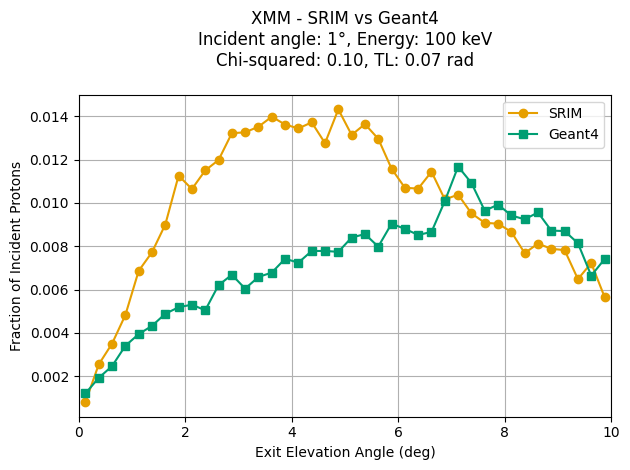

Chi-squared between SRIM and Geant4 energy ratio distributions: 0.183


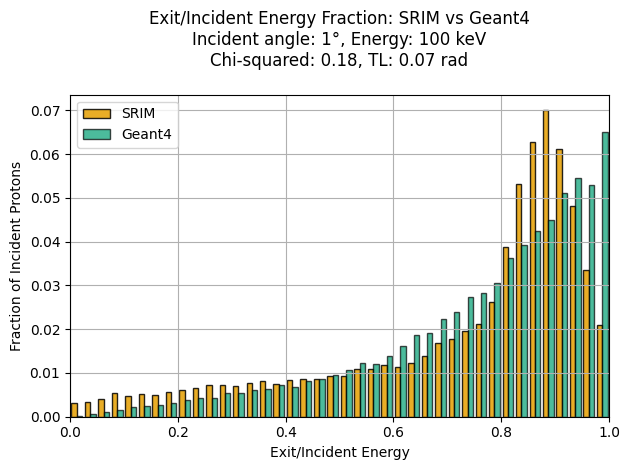

In [4]:
# Jupyter Notebook: Geant4 vs SRIM Analysis

# Cell 1: Imports and Parameters

# --- Parameters ---
SRIM_FILE = "SRIM/BACKSCAT_100.txt"
ROOT_FILE = "build/build/root/output_1deg_100keV_TL0.070rad.root"
ROOT_HIST_NAME = "Elevation;1"  # <-- Use your Geant4 elevation histogram name here!
N_INCIDENT = 50000
NBINS = 40
BIN_RANGE = (0, 1)

incident_energy = None
incident_energy_str = None
plot_title = "Exit/Incident Energy Fraction: SRIM vs Geant4"
with open(SRIM_FILE, "r") as f:
    header_lines = [next(f) for _ in range(11)]
    for line in header_lines:
        m = re.search(r"TRIM Calc\.\s*=\s*H\(([\d.,]+)\s*(keV|MeV|eV)\)", line)
        if m:
            incident_energy_val = float(m.group(1).replace(",", "."))
            incident_energy_unit = m.group(2)
            incident_energy_str = f"{incident_energy_val:g} {incident_energy_unit}"
            if incident_energy_unit == "MeV":
                incident_energy = incident_energy_val * 1e6
            elif incident_energy_unit == "keV":
                incident_energy = incident_energy_val * 1e3
            else:
                incident_energy = incident_energy_val
            plot_title = f"XMM - SRIM vs Geant4 1 degree incident, {incident_energy_str} Protons"
            break
if incident_energy is None:
    incident_energy = 5e5  # fallback
    incident_energy_str = "500 keV"
    print("Warning: Could not parse incident energy from SRIM file, using default 500 keV.")

energy_ratios = []
backscattered_count = 0
srim_elevations = []
with open(SRIM_FILE, "r") as f:
    for line in f:
        line = line.strip()
        if not line or not line.startswith("B"):
            continue
        line = line.replace(",", ".")
        line = re.sub(r"^B(\d+)", r"B \1", line)
        parts = line.split()
        try:
            energy = float(parts[3])
            ratio = energy / incident_energy
            energy_ratios.append(ratio)
            backscattered_count += 1

            # SRIM direction cosines: Cos(X), Cos(Y), Cos(Z) are parts[7], [8], [9]
            cos_x = float(parts[8])
            elevation_deg = np.degrees(np.arccos(cos_x)) - 90.0
            srim_elevations.append(elevation_deg)
        except Exception:
            continue

print(f"Backscattered protons in SRIM data: {backscattered_count} ({backscattered_count/N_INCIDENT:.2%})")

# Histogram SRIM data
srim_hist, bin_edges = np.histogram(energy_ratios, bins=NBINS, range=BIN_RANGE)
srim_hist = srim_hist / N_INCIDENT

# Histogram Geant4 data from ntuple
with uproot.open(ROOT_FILE) as f:
    tree = f["ExitData"]
    energy_ratio_g4 = tree["EnergyRatio"].array()

g4_hist, g4_edges = np.histogram(energy_ratio_g4, bins=NBINS, range=BIN_RANGE)
g4_hist = g4_hist / N_INCIDENT

ELEV_BINS = 40
ELEV_RANGE = (0, 10)

# SRIM elevation histogram
srim_elev_hist, elev_bin_edges = np.histogram(srim_elevations, bins=ELEV_BINS, range=ELEV_RANGE)
srim_elev_hist = srim_elev_hist / N_INCIDENT

theta_limit = None

# Geant4 elevation histogram from ntuple
with uproot.open(ROOT_FILE) as f:
    tree = f["ExitData"]
    elevation_g4 = tree["Elevation"].array()
    # if "RunInfo" in f:
    #         runinfo = f["RunInfo"]
    #         # uproot v4: use .arrays() or .array() depending on version
    #         arr = runinfo["MscThetaLimit"].array()
    #         if len(arr) > 0:
    #             theta_limit = arr[0]
# print(arr)
# if theta_limit is not None:
#     theta_limit_str = f"ThetaLimit: {theta_limit:.3g} rad"
# else:
#     theta_limit_str = "ThetaLimit: N/A"

# Example: ROOT_FILE = "build/build/root/output_1deg_1000keV_TL1.000rad.root"
theta_limit = None

# Extract theta limit from filename
match = re.search(r'_TL([0-9.]+)rad', os.path.basename(ROOT_FILE))
if match:
    theta_limit = float(match.group(1))
    theta_limit_str = f"{theta_limit:.3g} rad"
else:
    theta_limit_str = "ThetaLimit: N/A"

g4_elev_hist, g4_elev_edges = np.histogram(elevation_g4, bins=ELEV_BINS, range=ELEV_RANGE)
g4_elev_hist = g4_elev_hist / N_INCIDENT
g4_elev_bin_centers = 0.5 * (g4_elev_edges[:-1] + g4_elev_edges[1:])

# SRIM bin centers
srim_elev_bin_centers = 0.5 * (elev_bin_edges[:-1] + elev_bin_edges[1:])
width = (elev_bin_edges[1] - elev_bin_edges[0]) * 0.4

g4_interp = np.interp(srim_elev_bin_centers, g4_elev_bin_centers, g4_elev_hist)

# Avoid division by zero by adding a small epsilon
epsilon = 1e-12
chi2 = np.sum((srim_elev_hist - g4_interp) ** 2 / (g4_interp + epsilon))
print(f"Chi-squared between SRIM and Geant4 exit angle distributions: {chi2:.3f}")

# Print Geant4 backscattered count and fraction
g4_backscattered_count = np.sum(g4_elev_hist) * N_INCIDENT
print(f"Backscattered protons in Geant4 data: {int(g4_backscattered_count)} ({np.sum(g4_elev_hist):.2%})")

incident_angle_str = "1°"  # Or set dynamically if needed

plt.figure()
plt.plot(
    srim_elev_bin_centers, srim_elev_hist, 
    marker='o', linestyle='-', color="#E69F00", label="SRIM"
)
plt.plot(
    g4_elev_bin_centers, g4_elev_hist, 
    marker='s', linestyle='-', color="#009E73", label="Geant4"
)
plt.xlabel("Exit Elevation Angle (deg)")
plt.ylabel("Fraction of Incident Protons")
plt.title(
    f"XMM - SRIM vs Geant4\n"
    f"Incident angle: {incident_angle_str}, Energy: {incident_energy_str}\n"
    f"Chi-squared: {chi2:.2f}, TL: {theta_limit_str}\n"
    
)
plt.xlim(0, 10)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
width = (bin_edges[1] - bin_edges[0]) * 0.4

# For energy ratio distributions
g4_interp_energy = np.interp(bin_centers, 0.5 * (g4_edges[:-1] + g4_edges[1:]), g4_hist)
chi2_energy = np.sum((srim_hist - g4_interp_energy) ** 2 / (g4_interp_energy + epsilon))
print(f"Chi-squared between SRIM and Geant4 energy ratio distributions: {chi2_energy:.3f}")

plt.bar(bin_centers - width/2, srim_hist, width=width, label="SRIM", color="#E69F00", align="center", alpha=0.85, edgecolor="black")
plt.bar(bin_centers + width/2, g4_hist, width=width, label="Geant4", color="#009E73", align="center", alpha=0.7, edgecolor="black")

plt.xlabel("Exit/Incident Energy")
plt.ylabel("Fraction of Incident Protons")
plt.title(
    f"Exit/Incident Energy Fraction: SRIM vs Geant4\n"
    f"Incident angle: {incident_angle_str}, Energy: {incident_energy_str}\n"
    f"Chi-squared: {chi2_energy:.2f}, TL: {theta_limit_str}\n"
    
    
)
plt.xlim(0,1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


    

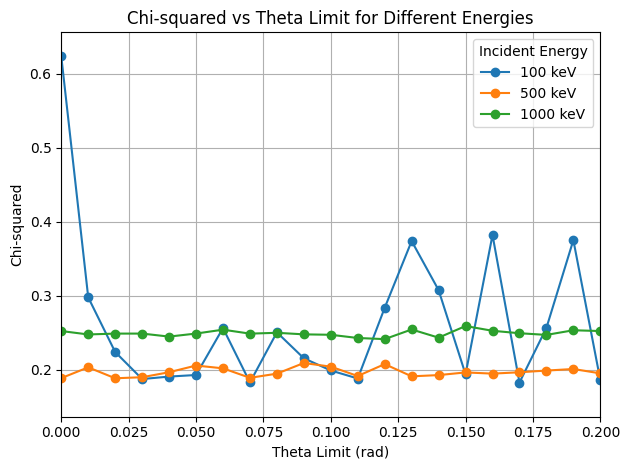

Best theta_limit in [0.0, 0.2] rad: 0.07 rad (combined chi2=0.62)


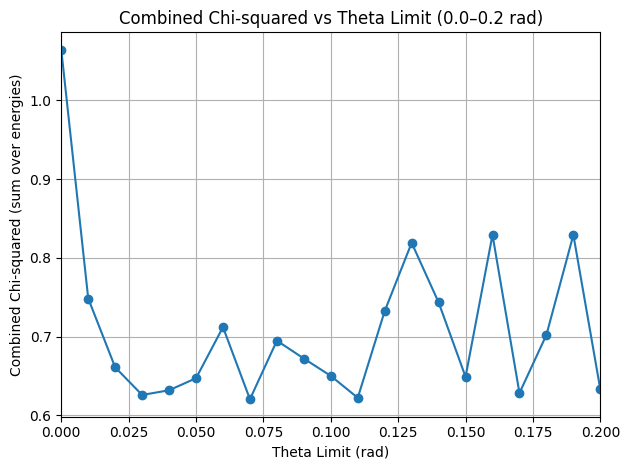

In [3]:

# --- Parameters ---
ENERGIES = [100, 500, 1000]
ANGLE = 1  # degree
N_INCIDENT = 50000
NBINS = 40
BIN_RANGE = (0, 1)
ROOT_DIR = "build/build/root"
SRIM_DIR = "SRIM"

def get_srim_hist(energy):
    srim_file = f"{SRIM_DIR}/BACKSCAT_{energy}.txt"
    incident_energy = energy * 1e3  # keV to eV
    energy_ratios = []
    with open(srim_file, "r") as f:
        for line in f:
            line = line.strip()
            if not line or not line.startswith("B"):
                continue
            line = line.replace(",", ".")
            parts = line.split()
            try:
                e = float(parts[3])
                ratio = e / incident_energy
                energy_ratios.append(ratio)
            except Exception:
                continue
    srim_hist, bin_edges = np.histogram(energy_ratios, bins=NBINS, range=BIN_RANGE)
    srim_hist = srim_hist / N_INCIDENT
    return srim_hist, bin_edges

def get_g4_hist(root_file):
    with uproot.open(root_file) as f:
        tree = f["ExitData"]
        energy_ratio_g4 = tree["EnergyRatio"].array()
    g4_hist, g4_edges = np.histogram(energy_ratio_g4, bins=NBINS, range=BIN_RANGE)
    g4_hist = g4_hist / N_INCIDENT
    return g4_hist, g4_edges

results = []


for energy in ENERGIES:
    srim_hist, bin_edges = get_srim_hist(energy)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    pattern = os.path.join(ROOT_DIR, f"output_{ANGLE}deg_{energy}keV_TL*.root")
    baap = 0
    for root_file in glob.glob(pattern):
        match = re.search(r'_TL([0-9]+(?:\.[0-9]+)?)rad', os.path.basename(root_file))
        baap += 1
        if not match:
            continue
        theta_limit = float(match.group(1))
        if not match:
            continue
        theta_limit = float(match.group(1))
        try:
            g4_hist, g4_edges = get_g4_hist(root_file)
        except Exception as e:
            print(f"Could not process {root_file}: {e}")
            continue
        g4_interp = np.interp(bin_centers, 0.5 * (g4_edges[:-1] + g4_edges[1:]), g4_hist)
        epsilon = 1e-12
        chi2 = np.sum((srim_hist - g4_interp) ** 2 / (g4_interp + epsilon))
        results.append((energy, theta_limit, chi2))
        # print(f"Energy: {energy} keV, ThetaLimit: {theta_limit:.3f} rad, chi2: {chi2:.3f}")




# Load the results (if not already in memory)
df = pd.read_csv("theta_scan_chi2.csv")
# Sort results by energy and theta_limit
results.sort(key=lambda x: (x[0], x[1]))

# If using pandas, do not drop duplicates unless you want to!
# If you want to keep all, just plot as is:
for energy in sorted(set(e for e, _, _ in results)):
    xs = [theta for e, theta, chi2 in results if e == energy]
    ys = [chi2 for e, theta, chi2 in results if e == energy]
    plt.plot(xs, ys, marker='o', label=f"{energy} keV")

# for energy in ENERGIES:
#     subset = [(theta, chi2) for e, theta, chi2 in results if e == energy]
#     if subset:
#         best = min(subset, key=lambda x: x[1])
#         print(f"Best theta_limit for {energy} keV: {best[0]:.2f} rad (chi2={best[1]:.2f})")

plt.xlabel("Theta Limit (rad)")
plt.ylabel("Chi-squared")
plt.title("Chi-squared vs Theta Limit for Different Energies")
plt.xlim(0.0,0.2)
plt.legend(title="Incident Energy")
plt.grid(True)
plt.tight_layout()
plt.show()


# Group chi2 by theta_limit across all energies
chi2_by_theta = defaultdict(list)
for e, theta, chi2 in results:
    chi2_by_theta[theta].append(chi2)

# Compute combined chi2 (sum or average) for each theta_limit
combined = []
for theta, chi2_list in chi2_by_theta.items():
    combined_chi2 = np.sum(chi2_list)  # or np.mean(chi2_list)
    combined.append((theta, combined_chi2))

# Only consider theta in [0.0, 0.2]
filtered = [(theta, chi2) for theta, chi2 in combined if 0.0 <= theta <= 0.2]

if filtered:
    best_theta, best_chi2 = min(filtered, key=lambda x: x[1])
    print(f"Best theta_limit in [0.0, 0.2] rad: {best_theta:.2f} rad (combined chi2={best_chi2:.2f})")
else:
    print("No theta_limit values in [0.0, 0.2] rad found.")

# Optional: plot only the filtered range
filtered.sort()
plt.figure()
plt.plot([t for t, _ in filtered], [c for _, c in filtered], marker='o')
plt.xlabel("Theta Limit (rad)")
plt.ylabel("Combined Chi-squared (sum over energies)")
plt.title("Combined Chi-squared vs Theta Limit (0.0–0.2 rad)")
plt.grid(True)
plt.xlim(0.0, 0.2)
plt.tight_layout()
plt.show()


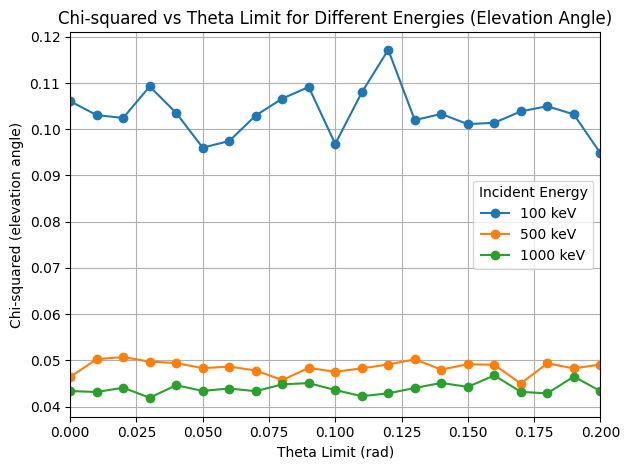

Best theta_limit for elevation angle in [0.0, 0.2] rad: 0.20 rad (combined chi2=0.19)


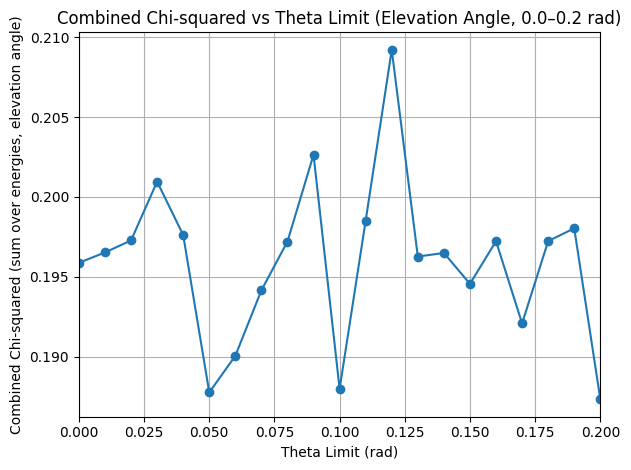

In [84]:
import os
import re
import uproot
import numpy as np
import glob
import matplotlib.pyplot as plt

ENERGIES = [100, 500, 1000]
ANGLE = 1  # degree (fixed)
N_INCIDENT = 50000
ELEV_BINS = 40
ELEV_RANGE = (0, 10)
ROOT_DIR = "build/build/root"
SRIM_DIR = "SRIM"

def get_srim_elev_hist(energy):
    srim_file = f"{SRIM_DIR}/BACKSCAT_{energy}.txt"
    if not os.path.exists(srim_file):
        return None, None
    srim_elevations = []
    with open(srim_file, "r") as f:
        for line in f:
            line = line.strip()
            if not line or not line.startswith("B"):
                continue
            line = line.replace(",", ".")
            parts = line.split()
            try:
                cos_x = float(parts[8])
                elevation_deg = np.degrees(np.arccos(cos_x)) - 90.0
                srim_elevations.append(elevation_deg)
            except Exception:
                continue
    srim_elev_hist, elev_bin_edges = np.histogram(srim_elevations, bins=ELEV_BINS, range=ELEV_RANGE)
    srim_elev_hist = srim_elev_hist / N_INCIDENT
    return srim_elev_hist, elev_bin_edges

def get_g4_elev_hist(root_file):
    with uproot.open(root_file) as f:
        tree = f["ExitData"]
        elevation_g4 = tree["Elevation"].array()
    g4_elev_hist, g4_elev_edges = np.histogram(elevation_g4, bins=ELEV_BINS, range=ELEV_RANGE)
    g4_elev_hist = g4_elev_hist / N_INCIDENT
    return g4_elev_hist, g4_elev_edges

results = []

for energy in ENERGIES:
    srim_elev_hist, elev_bin_edges = get_srim_elev_hist(energy)
    if srim_elev_hist is None:
        continue
    srim_elev_bin_centers = 0.5 * (elev_bin_edges[:-1] + elev_bin_edges[1:])
    pattern = os.path.join(ROOT_DIR, f"output_{ANGLE}deg_{energy}keV_TL*.root")
    for root_file in glob.glob(pattern):
        match = re.search(r'_TL([0-9.]+)rad', os.path.basename(root_file))
        if not match:
            continue
        theta_limit = float(match.group(1))
        try:
            g4_elev_hist, g4_elev_edges = get_g4_elev_hist(root_file)
        except Exception as e:
            print(f"Could not process {root_file}: {e}")
            continue
        g4_elev_bin_centers = 0.5 * (g4_elev_edges[:-1] + g4_elev_edges[1:])
        g4_interp = np.interp(srim_elev_bin_centers, g4_elev_bin_centers, g4_elev_hist)
        epsilon = 1e-12
        chi2 = np.sum((srim_elev_hist - g4_interp) ** 2 / (g4_interp + epsilon))
        results.append((energy, theta_limit, chi2))

# Sort and plot as in your example
results.sort(key=lambda x: (x[0], x[1]))

for energy in sorted(set(e for e, _, _ in results)):
    xs = [theta for e, theta, chi2 in results if e == energy]
    ys = [chi2 for e, theta, chi2 in results if e == energy]
    plt.plot(xs, ys, marker='o', label=f"{energy} keV")

plt.xlabel("Theta Limit (rad)")
plt.ylabel("Chi-squared (elevation angle)")
plt.title("Chi-squared vs Theta Limit for Different Energies (Elevation Angle)")
plt.legend(title="Incident Energy")
plt.xlim(0,0.2)
plt.grid(True)
plt.tight_layout()
plt.show()

# Group chi2 by theta_limit across all energies (for elevation angle)
chi2_by_theta = defaultdict(list)
for e, theta, chi2 in results:
    chi2_by_theta[theta].append(chi2)

# Compute combined chi2 (sum or average) for each theta_limit
combined = []
for theta, chi2_list in chi2_by_theta.items():
    combined_chi2 = np.sum(chi2_list)  # or np.mean(chi2_list)
    combined.append((theta, combined_chi2))

# Only consider theta in [0.0, 0.2]
filtered = [(theta, chi2) for theta, chi2 in combined if 0.0 <= theta <= 0.2]

if filtered:
    best_theta, best_chi2 = min(filtered, key=lambda x: x[1])
    print(f"Best theta_limit for elevation angle in [0.0, 0.2] rad: {best_theta:.2f} rad (combined chi2={best_chi2:.2f})")
else:
    print("No theta_limit values in [0.0, 0.2] rad found for elevation angle.")

# Optional: plot only the filtered range
filtered.sort()
plt.figure()
plt.plot([t for t, _ in filtered], [c for _, c in filtered], marker='o')
plt.xlabel("Theta Limit (rad)")
plt.ylabel("Combined Chi-squared (sum over energies, elevation angle)")
plt.title("Combined Chi-squared vs Theta Limit (Elevation Angle, 0.0–0.2 rad)")
plt.grid(True)
plt.xlim(0.0, 0.2)
plt.tight_layout()
plt.show()

In [76]:
# Cell 2: XZ and YZ projection scatter plots from Geant4 ntuple

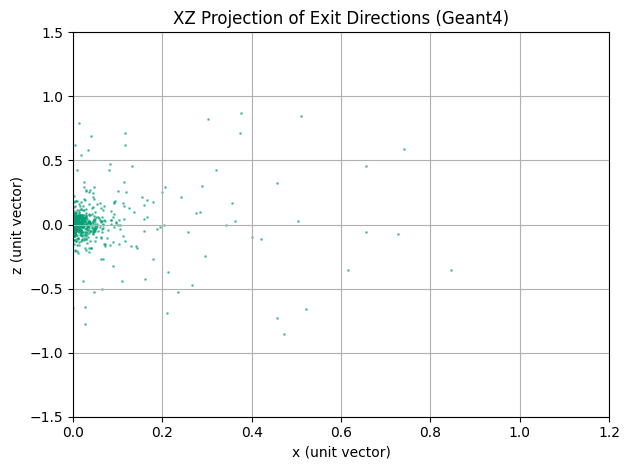

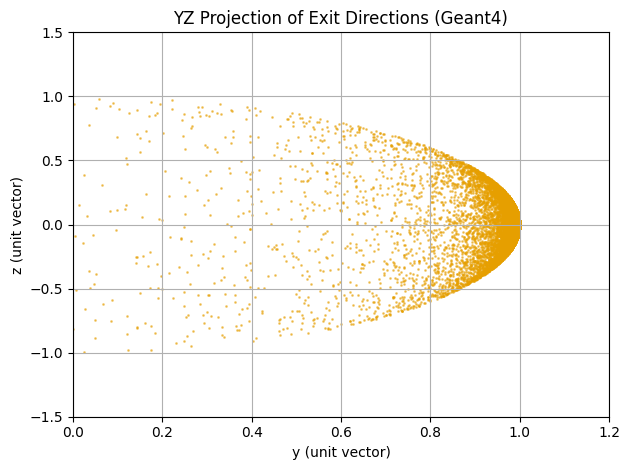

In [77]:
with uproot.open(ROOT_FILE) as f:
    tree = f["ExitData"]
    x_g4 = tree["x"].array()
    y_g4 = tree["y"].array()
    z_g4 = tree["z"].array()

plt.figure()
plt.scatter(x_g4, z_g4, s=1, alpha=0.5, color="#009E73")
plt.xlabel("x (unit vector)")
plt.ylabel("z (unit vector)")
plt.title("XZ Projection of Exit Directions (Geant4)")
plt.xlim(0.0, 1.2)
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(y_g4, z_g4, s=1, alpha=0.5, color="#E69F00")
plt.xlabel("y (unit vector)")
plt.ylabel("z (unit vector)")
plt.title("YZ Projection of Exit Directions (Geant4)")
plt.xlim(0.0, 1.2)
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
# Cell 10: Scattering efficiency calculation and plot (Geant4)

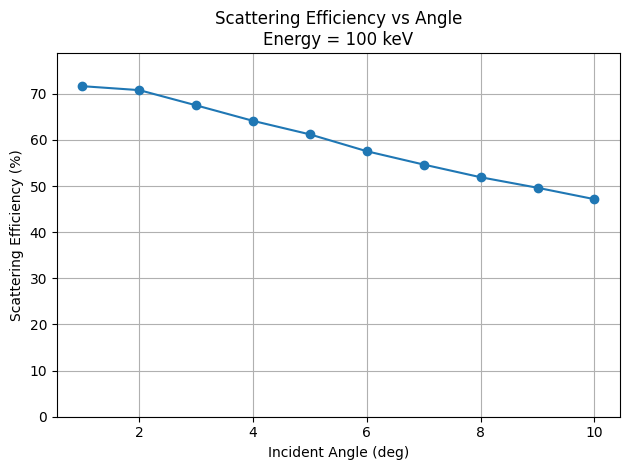

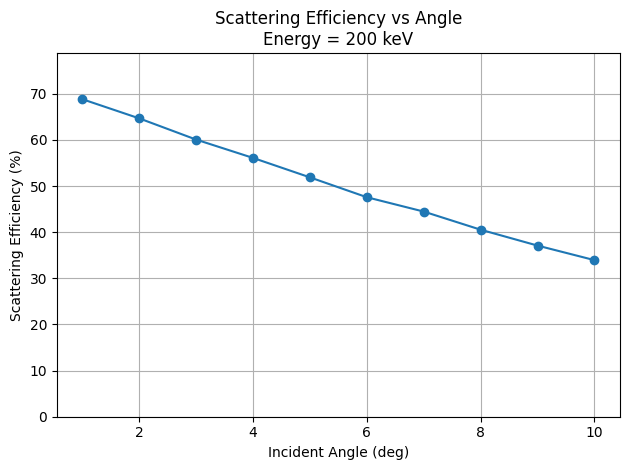

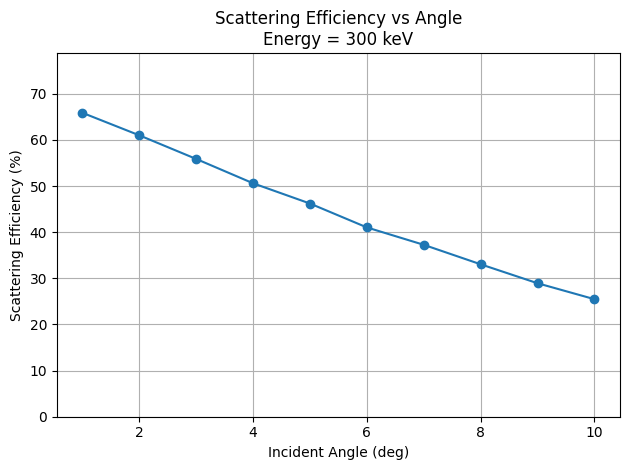

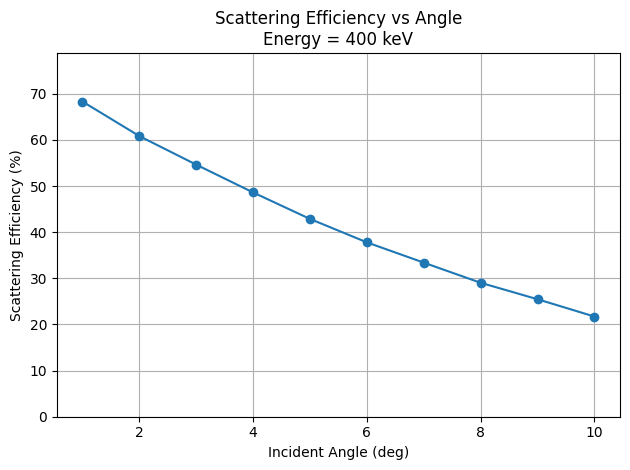

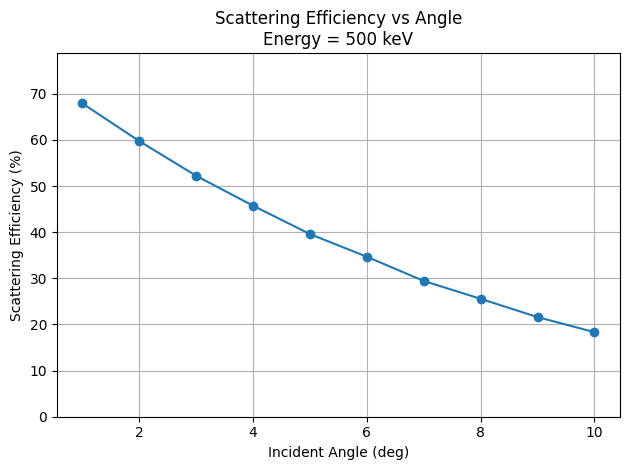

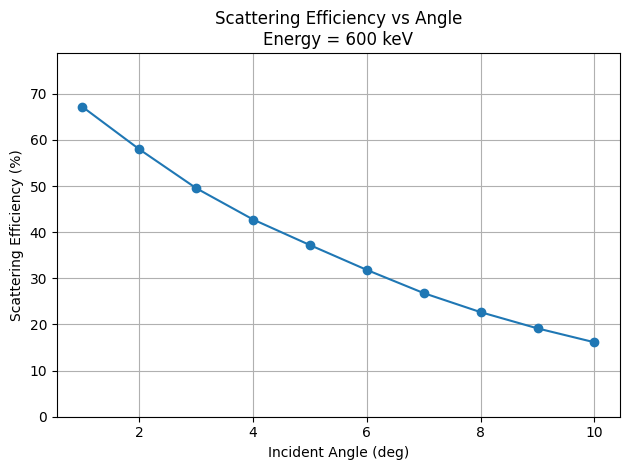

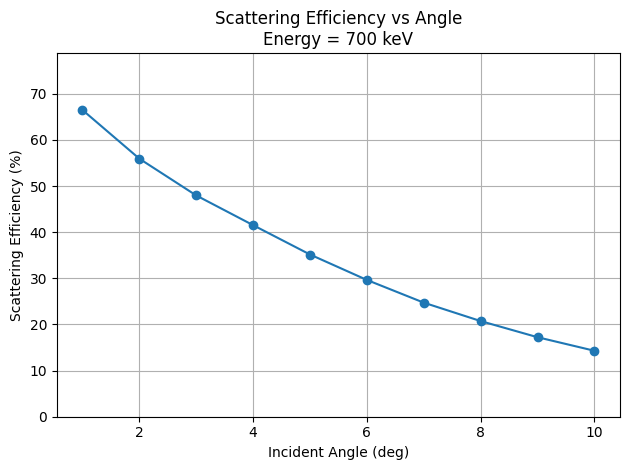

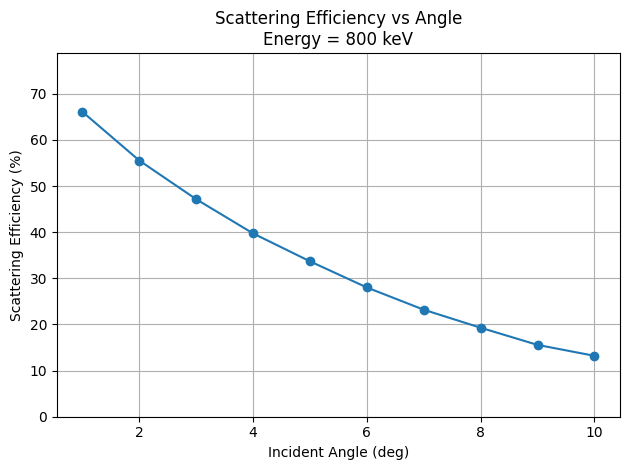

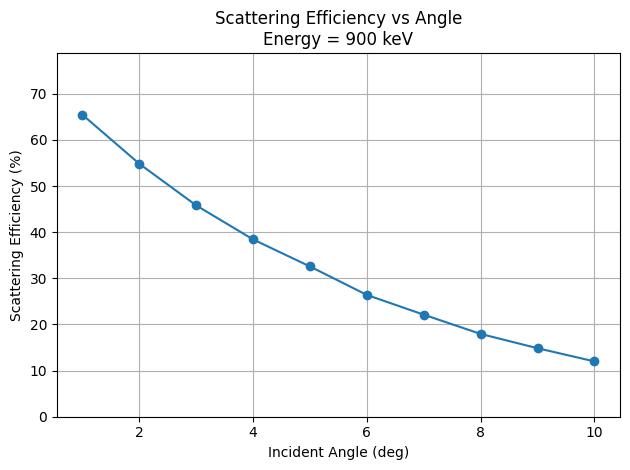

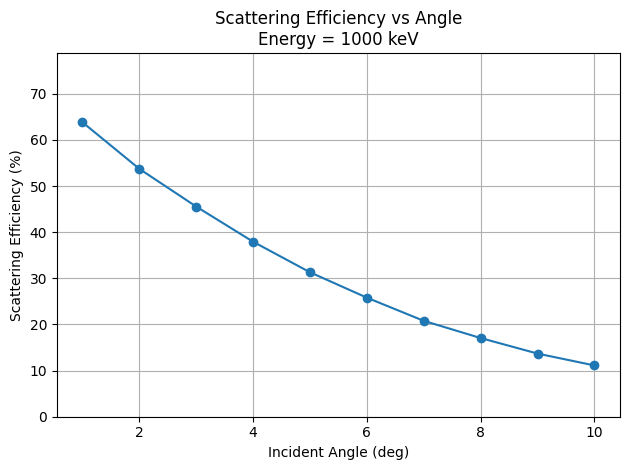

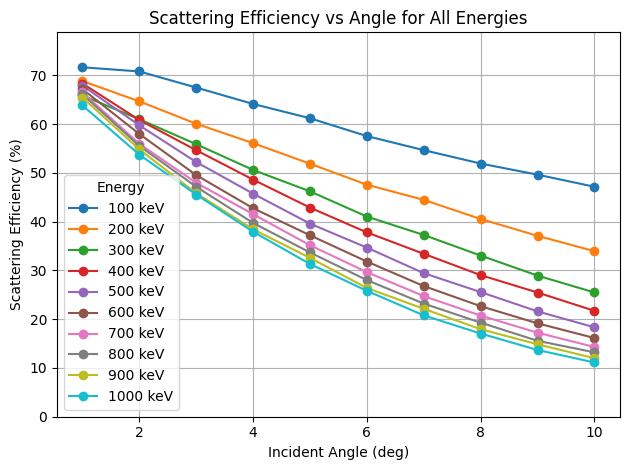

In [79]:
N_INCIDENT = 50000  # Update if needed
angle_range = range(1, 11)  # 1deg to 10deg
energy_range = range(100, 1001, 100)  # 100 to 1000 keV
eff_matrix = np.full((len(energy_range), len(angle_range)), np.nan)  # shape: (energies, angles)

for i, energy in enumerate(energy_range):
    for j, angle in enumerate(angle_range):
        root_file = f"build/build/root/output_{angle}deg_{energy}keV.root"
        if not os.path.exists(root_file):
            continue
        with uproot.open(root_file) as f:
            tree = f["ExitData"]
            n_scattered = tree.num_entries
            eff_matrix[i, j] = 100 * n_scattered / N_INCIDENT

# Plot one figure per energy
for i, energy in enumerate(energy_range):
    plt.figure()
    plt.plot(angle_range, eff_matrix[i, :], marker='o')
    plt.xlabel("Incident Angle (deg)")
    plt.ylabel("Scattering Efficiency (%)")
    plt.title(f"Scattering Efficiency vs Angle\nEnergy = {energy} keV")
    plt.ylim(0, np.nanmax(eff_matrix) * 1.1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot all energies together
plt.figure()
for i, energy in enumerate(energy_range):
    plt.plot(angle_range, eff_matrix[i, :], marker='o', label=f"{energy} keV")
plt.xlabel("Incident Angle (deg)")
plt.ylabel("Scattering Efficiency (%)")
plt.title("Scattering Efficiency vs Angle for All Energies")
plt.legend(title="Energy")
plt.ylim(0, np.nanmax(eff_matrix) * 1.1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
# Cell 11: SRIM scattering efficiency calculation and plot

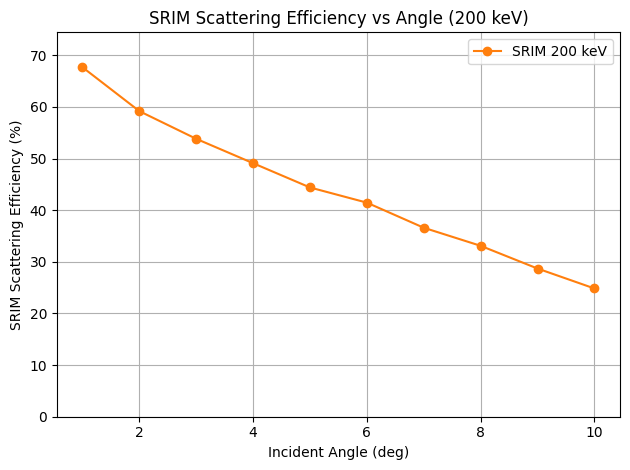

In [81]:
srim_N_INCIDENT = 5000
angle_range = range(1, 11)  # 1deg to 10deg
energy = 200  # Only 200 keV

srim_eff = np.full(len(angle_range), np.nan)

for j, angle in enumerate(angle_range):
    srim_file = f"SRIM/BACKSCAT_{energy}_{angle}deg.txt"
    if not os.path.exists(srim_file):
        continue
    n_backscattered = 0
    with open(srim_file, "r") as f:
        for line in f:
            line = line.strip()
            if not line or not line.startswith("B"):
                continue
            n_backscattered += 1
    srim_eff[j] = 100 * n_backscattered / srim_N_INCIDENT

plt.figure()
plt.plot(angle_range, srim_eff, marker='o', color='tab:orange', label="SRIM 200 keV")
plt.xlabel("Incident Angle (deg)")
plt.ylabel("SRIM Scattering Efficiency (%)")
plt.title("SRIM Scattering Efficiency vs Angle (200 keV)")
plt.ylim(0, np.nanmax(srim_eff) * 1.1)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()